In [49]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## **1. Create Folder structure**

In [51]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## **2. Collecting datasets**

> **Collect ankor images**

In [5]:
# http://vis-www.cs.umass.edu/lfw/

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

> **Collect positive and anchor classes**

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/1a83ebac-247f-11ed-aa6b-c9f7e95d6635.jpg'

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

## **3. Data Augumentation**

In [7]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [8]:
import os
import uuid

In [9]:
#img_path = "/home/tuandinh/Desktop/Facial Recognition/data/anchor/76bd99fe-23e6-11ed-bfcb-5359c2c96ea9.jpg"
img_path = os.path.join(ANC_PATH, '2a01ea1d-2471-11ed-aa6b-c9f7e95d6635.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

2022-08-25 17:06:34.229296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 17:06:34.229837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tuandinh/Desktop/Facial Recognition/tuanenv/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-25 17:06:34.229960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tuandinh/Desktop/Facial Recognition/tuanenv/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-25 17:06:34.230062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Coul

In [10]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## **4. Load and Preprocess Images**

### **Load images**

In [52]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [53]:
dir_test = anchor.as_numpy_iterator()

In [54]:
print(dir_test.next())

b'data/anchor/20a3acec-247f-11ed-aa6b-c9f7e95d6635.jpg'


### **Preprocessing**

In [55]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load image
    img = tf.image.decode_jpeg(byte_img)

    #preprocessing step
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [56]:
img = preprocess('data/anchor/7ddb0198-23e1-11ed-bfcb-5359c2c96ea9.jpg')

In [57]:
img.numpy().max() 

1.0

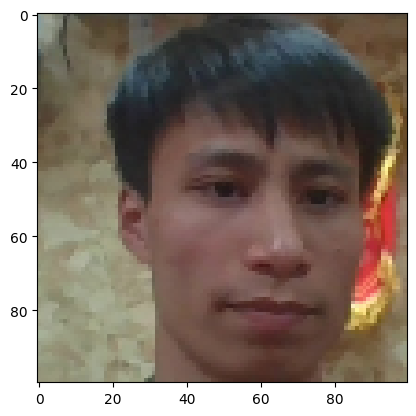

In [58]:
plt.imshow(img)

### **Create Labelled Dataset**

+ ankor , positive => 1,1,1,1,1
+ ankor , negative = 0,0,0,0,0

In [59]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [60]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [61]:
samples = data.as_numpy_iterator()

In [62]:
example = samples.next()
len(example)

3

In [63]:
example

(b'data/anchor/bfb3bc0e-23e1-11ed-bfcb-5359c2c96ea9.jpg',
 b'data/positive/6b78c67f-247f-11ed-aa6b-c9f7e95d6635.jpg',
 1.0)

### **Build Train and Test Partition**

In [64]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [65]:
res = preprocess_twin(*example)
len(res)

3

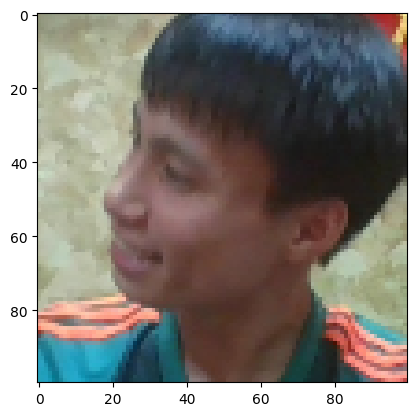

In [66]:
plt.imshow(res[0])

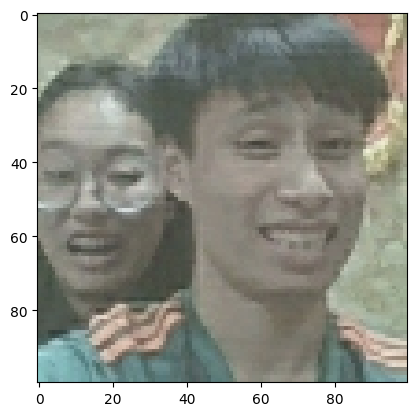

In [67]:
plt.imshow(res[1])

In [68]:
print(f"Result if positive {res[2]}")

Result if positive 1.0


In [69]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [70]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [71]:
round(len(data)*0.7)

158

In [72]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) # bo qua data duoc chon lam training set
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## **Model Engineering**

In [73]:
# Examples how to NN works
inp = Input(shape=(105,105,3), name = "image_input")
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64,(2,2), padding="same")(c1)
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d_6')>

In [74]:
  # Second blocks
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_7')>

In [75]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_8')>

In [76]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_3')>

In [77]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [78]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       26

In [79]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [80]:
embedding = make_embedding()

In [81]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

### **Build Distance Layer**

In [82]:
class L1Dist(Layer):
    # Init method
    def __init__(self, **kwargs):
        super().__init__()
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [83]:
l1 = L1Dist()

### **Make Siamese Model**

In [41]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [42]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [43]:
siamese_layer = L1Dist()

In [44]:
distances = siamese_layer(inp_embedding, val_embedding)

In [45]:
classifier = Dense(1, activation='sigmoid')(distances)

In [46]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [47]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [48]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [84]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [86]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## **Training**

### ***Setup loss and optimizer***

In [87]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [88]:
opt = tf.keras.optimizers.Adam()

### **Establish Checkpoints** 

In [89]:
check_point_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(check_point_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### **Train step Function**

In [91]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [92]:
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [93]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    # Return loss
    return loss

### **Build Training Loop**

In [94]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [95]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # hien tien trinh
        
        # Creating a metric object 
        r = Recall() # Computes the recall of the predictions with respect to the labels.
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### **Train the Model**

In [96]:
EPOCHS = 50

In [97]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 4/10 [===========>..................] - ETA: 2:20

KeyboardInterrupt: 